# Projet 7 - Prédiction de revenus

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
from scipy.stats import ks_2samp
from collections import Counter

In [2]:
sns.set_palette('Set1')

In [3]:
def lorenz_curve(X):
  """ Fonction qui trace la courbe de Lorenz d'une variable donnée.
  Il prend comme argument un objet de type array (numpy)
  """
  X_lorenz = np.cumsum(np.sort(X)) / X.sum()
  X_lorenz = np.insert(X_lorenz, 0, 0) 
  X_lorenz[0], X_lorenz[-1]
  fig, ax = plt.subplots(figsize=[10,10])
  ## scatter plot of Lorenz curve
  _ = ax.plot(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='red', label=i)
  _ = ax.plot([0,1], [0,1], color='k', label='bissectrice')
  _ = plt.title('Courbe de Lorenz de ' + i)
  _ = plt.legend()
  _ = plt.show()

def generate_incomes(n, pj):
  # On génère les revenus des parents (exprimés en logs) selon une loi normale.
  # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le calcul de la classe de revenu)
  ln_y_parent = st.norm(0,1).rvs(size=n)
  # Génération d'une réalisation du terme d'erreur epsilon
  residues = st.norm(0,1).rvs(size=n)
  return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

def quantiles(l, nb_quantiles):
  # obj: savoir pour chaque valeur de l, à quel quantile elle appartient
  quantiles_list = np.array([np.percentile(l,int(i*100/nb_quantiles)) for i in range(1,nb_quantiles+1)]) 
  # on récupère la valeur de chaque quantile
  res = [(elt > quantiles_list).sum()+1 for elt in l] 
  # combien de quantile(s) sont plus grand que la valeur (chaque élément de l)
  # si elt est plus petit que tous les quantiles -> 1er quantile
  # si elt est plus grand qu'un seul quantile -> 2ème quantile
  # etc
  return pd.Series(res)

def compute_quantiles(y_child, y_parents, nb_quantiles):
  y_child = pd.Series(y_child)
  y_parents = pd.Series(y_parents)
  c_i_child = quantiles(y_child, nb_quantiles)
  c_i_parent = quantiles(y_parents, nb_quantiles)
  sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
  sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
  return sample

def distribution(counts, nb_quantiles):
  distrib = []
  total = counts["counts"].sum()

  if total == 0 :
    return [0] * nb_quantiles

  for q_p in range(1, nb_quantiles+1):
    subset = counts[counts.c_i_parent == q_p]
    if len(subset):
      nb = subset["counts"].values[0]
      distrib += [nb / total]
    else:
      distrib += [0]
  return distrib

def conditional_distributions(sample, nb_quantiles):
  counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
  counts = counts.reset_index()
  counts.columns = ["c_i_child","c_i_parent","counts"]
  
  mat = []
  for child_quantile in np.arange(nb_quantiles)+1:
    subset = counts[counts.c_i_child == child_quantile]
    mat += [distribution(subset, nb_quantiles)]
  return np.array(mat)

def plot_conditional_distributions(p, cd, nb_quantiles):
  plt.figure()
  cumul = np.array([0] * nb_quantiles)
  
  for i, child_quantile in enumerate(cd):
    plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label= str(i+1) +"e")
    cumul = cumul + np.array(child_quantile)

  plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
  plt.title("p=" + str(p))
  plt.legend(loc='best')
  plt.xlabel("quantile parents")
  plt.ylabel("probabilité du quantile enfant")
  plt.show()

def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child-1, c_i_parent-1]

In [4]:
data = pd.read_csv('data-projet7.csv',decimal=',')
data

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11594,COD,2008,96,100,810.62330,303.19305
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305


In [5]:
pays_iso = pd.read_csv('sql-pays.csv', header=None)
pays_iso

,0,1,2,3,4,5
0,1,4,AF,AFG,Afghanistan,Afghanistan
1,2,8,AL,ALB,Albanie,Albania
2,3,10,AQ,ATA,Antarctique,Antarctica
3,4,12,DZ,DZA,Algérie,Algeria
4,5,16,AS,ASM,Samoa Américaines,American Samoa
...,...,...,...,...,...,...
236,237,876,WF,WLF,Wallis et Futuna,Wallis and Futuna
237,238,882,WS,WSM,Samoa,Samoa
238,239,887,YE,YEM,Yémen,Yemen
239,240,891,CS,SCG,Serbie-et-Monténégro,Serbia and Montenegro


In [6]:
pays_iso.columns = ['0', '1', '2', 'iso_code', 'Country', '5']
pays_iso = pays_iso[['iso_code', 'Country']]
pays_iso

,iso_code,Country
0,AFG,Afghanistan
1,ALB,Albanie
2,ATA,Antarctique
3,DZA,Algérie
4,ASM,Samoa Américaines
...,...,...
236,WLF,Wallis et Futuna
237,WSM,Samoa
238,YEM,Yémen
239,SCG,Serbie-et-Monténégro


In [7]:
data = pd.merge(data, pays_iso, left_on='country', right_on='iso_code')


In [8]:
data = data[['iso_code', 'country', 'Country', 'year_survey', 'quantile', 'nb_quantiles', 'income', 'gdpppp']]
data = data.drop('country', axis=1)
data

,iso_code,Country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,Albanie,2008,1,100,728.89795,7297.00000
1,ALB,Albanie,2008,2,100,916.66235,7297.00000
2,ALB,Albanie,2008,3,100,1010.91600,7297.00000
3,ALB,Albanie,2008,4,100,1086.90780,7297.00000
4,ALB,Albanie,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...,...
11294,COD,République Démocratique du Congo,2008,96,100,810.62330,303.19305
11295,COD,République Démocratique du Congo,2008,97,100,911.78340,303.19305
11296,COD,République Démocratique du Congo,2008,98,100,1057.80740,303.19305
11297,COD,République Démocratique du Congo,2008,99,100,1286.60290,303.19305


In [9]:
population = pd.read_csv('population_2008-2018.csv.csv')
population = population[['Zone', 'Année', 'Valeur']]
population = population.rename(columns={"Zone":'Country', "Valeur":"population 100%"})
population = population[population.Année != 2008]
population['population 100%'] = 1000 * population['population 100%']
population

,Country,Année,population 100%
1,Afghanistan,2018,37171921.0
3,Afrique du Sud,2018,57792518.0
5,Albanie,2018,2882740.0
7,Algérie,2018,42228408.0
9,Allemagne,2018,83124418.0
...,...,...,...
459,Venezuela (République bolivarienne du),2018,28887118.0
461,Viet Nam,2018,95545962.0
463,Yémen,2018,28498683.0
465,Zambie,2018,17351708.0


In [10]:
data = pd.merge(data, population, left_on='Country', right_on='Country')
data

,iso_code,Country,year_survey,quantile,nb_quantiles,income,gdpppp,Année,population 100%
0,ALB,Albanie,2008,1,100,728.89795,7297.0,2018,2882740.0
1,ALB,Albanie,2008,2,100,916.66235,7297.0,2018,2882740.0
2,ALB,Albanie,2008,3,100,1010.91600,7297.0,2018,2882740.0
3,ALB,Albanie,2008,4,100,1086.90780,7297.0,2018,2882740.0
4,ALB,Albanie,2008,5,100,1132.69970,7297.0,2018,2882740.0
...,...,...,...,...,...,...,...,...,...
9794,ZAF,Afrique du Sud,2008,96,100,24553.56800,9602.0,2018,57792518.0
9795,ZAF,Afrique du Sud,2008,97,100,28858.03100,9602.0,2018,57792518.0
9796,ZAF,Afrique du Sud,2008,98,100,35750.29000,9602.0,2018,57792518.0
9797,ZAF,Afrique du Sud,2008,99,100,46297.31600,9602.0,2018,57792518.0


In [11]:
data['population 100%'] = data['population 100%'] / 100
data = data.rename(columns={'population 100%': 'population_quantile'})
data

,iso_code,Country,year_survey,quantile,nb_quantiles,income,gdpppp,Année,population_quantile
0,ALB,Albanie,2008,1,100,728.89795,7297.0,2018,28827.40
1,ALB,Albanie,2008,2,100,916.66235,7297.0,2018,28827.40
2,ALB,Albanie,2008,3,100,1010.91600,7297.0,2018,28827.40
3,ALB,Albanie,2008,4,100,1086.90780,7297.0,2018,28827.40
4,ALB,Albanie,2008,5,100,1132.69970,7297.0,2018,28827.40
...,...,...,...,...,...,...,...,...,...
9794,ZAF,Afrique du Sud,2008,96,100,24553.56800,9602.0,2018,577925.18
9795,ZAF,Afrique du Sud,2008,97,100,28858.03100,9602.0,2018,577925.18
9796,ZAF,Afrique du Sud,2008,98,100,35750.29000,9602.0,2018,577925.18
9797,ZAF,Afrique du Sud,2008,99,100,46297.31600,9602.0,2018,577925.18


### Mission 1 - Résumé des données


Résumez les données utilisées :
- Année(s) des données utilisées ;
- Nombre de pays présents ;
- Population couverte par l'analyse (en termes de pourcentage de la population mondiale).

In [12]:
year_survey = data['year_survey'].unique()
print(np.sort(year_survey))

[2006 2007 2008 2009 2010 2011]


In [13]:
country = data['Country'].unique()
print('Nombre de pays : ', len(country))
print('Liste des pays : \n', country)

Nombre de pays :  98
Liste des pays : 
 ['Albanie' 'Argentine' 'Arménie' 'Autriche' 'Azerbaïdjan' 'Belgique'
 'Burkina Faso' 'Bangladesh' 'Bulgarie' 'Bosnie-Herzégovine' 'Bélarus'
 'Brésil' 'Bhoutan' 'Canada' 'Chili' 'Chine' "Côte d'Ivoire" 'Cameroun'
 'Colombie' 'Costa Rica' 'Chypre' 'Allemagne' 'Danemark' 'Équateur'
 'Égypte' 'Espagne' 'Estonie' 'Finlande' 'Fidji' 'France' 'Géorgie'
 'Ghana' 'Guinée' 'Grèce' 'Guatemala' 'Honduras' 'Croatie' 'Hongrie'
 'Indonésie' 'Inde' 'Irlande' 'Iraq' 'Islande' 'Israël' 'Italie'
 'Jordanie' 'Japon' 'Kazakhstan' 'Kenya' 'Kirghizistan' 'Cambodge'
 'République de Corée' 'Libéria' 'Sri Lanka' 'Lituanie' 'Luxembourg'
 'Lettonie' 'Maroc' 'République de Moldova' 'Madagascar' 'Mexique' 'Mali'
 'Mongolie' 'Mozambique' 'Mauritanie' 'Malawi' 'Malaisie' 'Niger'
 'Nigéria' 'Nicaragua' 'Pays-Bas' 'Norvège' 'Népal' 'Pakistan' 'Panama'
 'Pérou' 'Philippines' 'Pologne' 'Portugal' 'Paraguay' 'Roumanie'
 'Fédération de Russie' 'Soudan' 'El Salvador' 'Slovaquie' 'Slov

In [14]:
# Calcul de la population couverte
pop_total = sum(population['population 100%'])
pop_data = data['population_quantile'].groupby(data['Country']).sum()
pourcent_pop_ech = round((pop_data.sum()/pop_total) * 100, 2)
print('Population couverte par l\'analyse : ' + str(pourcent_pop_ech) + '%.')

Population couverte par l'analyse : 69.13%.


In [15]:
data.isnull().sum()

iso_code               0
Country                0
year_survey            0
quantile               0
nb_quantiles           0
income                 0
gdpppp                 0
Année                  0
population_quantile    0
dtype: int64

- De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?

Centiles (= 100 quantiles)

- Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

Ce découpage permet de réduire la taille de l'échantillon. De plus, on va avoir tendance à voir moins de valeurs qui vont être influencés par des valeurs aberrantes comme cela serait le cas pour une moyenne par exemple.

Définition de méthode Eltöte-Köves-Szulc : il s'agit d'une méthode statistique qui permet de calculer la parité de pouvoir d'achat. Elle a l'avantage de donner un poids à chaque pays et ainsi favoriser la comparaison entre différents pays.

### Mission 2 - Distribution des richesses dans notre échantillon

Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.



In [16]:
data

,iso_code,Country,year_survey,quantile,nb_quantiles,income,gdpppp,Année,population_quantile
0,ALB,Albanie,2008,1,100,728.89795,7297.0,2018,28827.40
1,ALB,Albanie,2008,2,100,916.66235,7297.0,2018,28827.40
2,ALB,Albanie,2008,3,100,1010.91600,7297.0,2018,28827.40
3,ALB,Albanie,2008,4,100,1086.90780,7297.0,2018,28827.40
4,ALB,Albanie,2008,5,100,1132.69970,7297.0,2018,28827.40
...,...,...,...,...,...,...,...,...,...
9794,ZAF,Afrique du Sud,2008,96,100,24553.56800,9602.0,2018,577925.18
9795,ZAF,Afrique du Sud,2008,97,100,28858.03100,9602.0,2018,577925.18
9796,ZAF,Afrique du Sud,2008,98,100,35750.29000,9602.0,2018,577925.18
9797,ZAF,Afrique du Sud,2008,99,100,46297.31600,9602.0,2018,577925.18


In [17]:
data = data.set_index('iso_code')

In [18]:
df = data.loc(axis=0)['FRA', 'ISL', 'EST', 'ARG', 'ECU', 'RUS'].reset_index()

In [19]:
df = df.sort_values('iso_code')
df

,iso_code,Country,year_survey,quantile,nb_quantiles,income,gdpppp,Année,population_quantile
351,ARG,Argentine,2008,52,100,4321.9460,13220.0,2018,443611.50
372,ARG,Argentine,2008,73,100,6826.5220,13220.0,2018,443611.50
371,ARG,Argentine,2008,72,100,6696.6587,13220.0,2018,443611.50
370,ARG,Argentine,2008,71,100,6600.3413,13220.0,2018,443611.50
369,ARG,Argentine,2008,70,100,6448.2114,13220.0,2018,443611.50
...,...,...,...,...,...,...,...,...,...
527,RUS,Fédération de Russie,2008,28,100,3435.8160,14766.0,2018,1457340.38
526,RUS,Fédération de Russie,2008,27,100,3373.1730,14766.0,2018,1457340.38
525,RUS,Fédération de Russie,2008,26,100,3312.1836,14766.0,2018,1457340.38
535,RUS,Fédération de Russie,2008,36,100,3983.6940,14766.0,2018,1457340.38


In [20]:
# modification de la classe de 'income'
# création de la classe 'income_log10'
df['income'] = df['income'].apply(lambda x: float(x))
df['income_log10'] = df['income'].apply(lambda x: math.log10(x)) 
df.head()

,iso_code,Country,year_survey,quantile,nb_quantiles,income,gdpppp,Année,population_quantile,income_log10
351,ARG,Argentine,2008,52,100,4321.9460,13220.0,2018,443611.5,3.635679
372,ARG,Argentine,2008,73,100,6826.5220,13220.0,2018,443611.5,3.834199
371,ARG,Argentine,2008,72,100,6696.6587,13220.0,2018,443611.5,3.825858
370,ARG,Argentine,2008,71,100,6600.3413,13220.0,2018,443611.5,3.819566
369,ARG,Argentine,2008,70,100,6448.2114,13220.0,2018,443611.5,3.809439


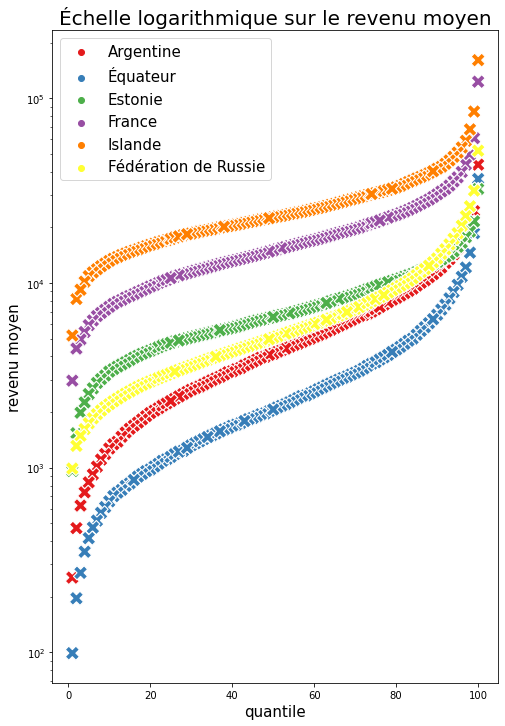

In [21]:
plt.figure(figsize=(8, 12))

ax = sns.scatterplot(
    data=df, x='quantile', y='income', 
    hue='Country', marker='X', s=200)
ax.set(yscale="log")

plt.title('Échelle logarithmique sur le revenu moyen', size=20)
plt.ylabel("revenu moyen", size=15)
plt.xlabel("quantile", size=15)
plt.legend(prop={"size":15})

plt.savefig("07-Echelle logarithmique sur le revenu moyen.jpg")

plt.show()

Représentez la courbe de Lorenz de chacun des pays choisis.

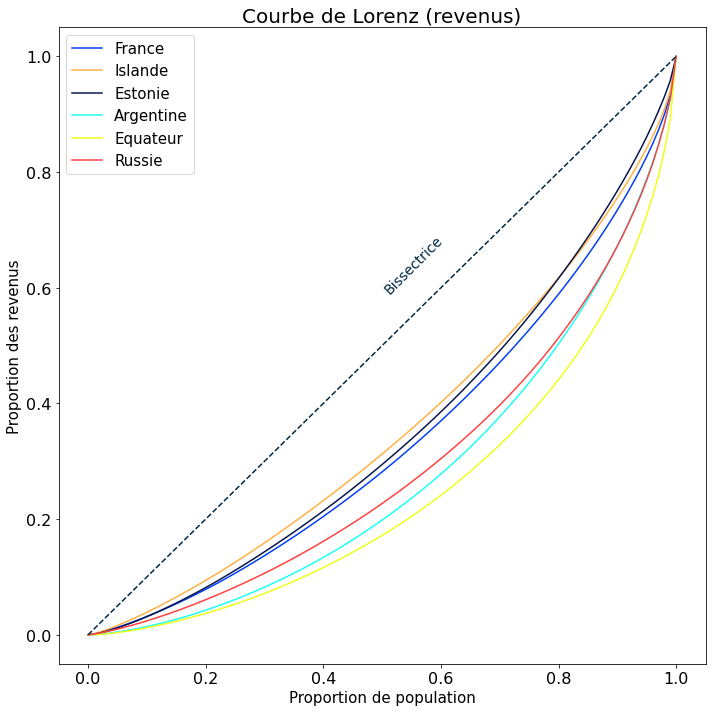

In [22]:
income_fra = df[df['iso_code'] == 'FRA']
income_isl = df[df['iso_code'] == 'ISL']
income_est = df[df['iso_code'] == 'EST']
income_arg = df[df['iso_code'] == 'ARG']
income_ecu = df[df['iso_code'] == 'ECU']
income_rus = df[df['iso_code'] == 'RUS']

incomes_fra = income_fra['income'].values
lorenz_fra = np.cumsum(np.sort(incomes_fra)) / incomes_fra.sum()
lorenz_fra = np.append([0], lorenz_fra)

incomes_isl = income_isl['income'].values
lorenz_isl = np.cumsum(np.sort(incomes_isl)) / incomes_isl.sum()
lorenz_isl = np.append([0], lorenz_isl)

incomes_est = income_est['income'].values
lorenz_est = np.cumsum(np.sort(incomes_est)) / incomes_est.sum()
lorenz_est = np.append([0], lorenz_est)

incomes_arg = income_arg['income'].values
lorenz_arg = np.cumsum(np.sort(incomes_arg)) / incomes_arg.sum()
lorenz_arg = np.append([0], lorenz_arg)

incomes_ecu = income_ecu['income'].values
lorenz_ecu = np.cumsum(np.sort(incomes_ecu)) / incomes_ecu.sum()
lorenz_ecu = np.append([0], lorenz_ecu)

incomes_rus = income_rus['income'].values
lorenz_rus = np.cumsum(np.sort(incomes_rus)) / incomes_rus.sum()
lorenz_rus = np.append([0], lorenz_rus)

plt.figure(figsize=(10,10))

plt.plot(np.linspace(0,1,len(lorenz_fra)),lorenz_fra, color='#023DF9')
plt.plot(np.linspace(0,1,len(lorenz_isl)),lorenz_isl, color='#FFB141')
plt.plot(np.linspace(0,1,len(lorenz_est)),lorenz_est, color='#07154C')
plt.plot(np.linspace(0,1,len(lorenz_arg)),lorenz_arg, color='#1AFFF6')
plt.plot(np.linspace(0,1,len(lorenz_ecu)),lorenz_ecu, color='#EEFF1A')
plt.plot(np.linspace(0,1,len(lorenz_rus)),lorenz_rus, color='#FF4141')


x = [0, 1]
y = [0, 1]
plt.plot(x, y, '#002740', linestyle='--', label='Médiatrice')
plt.text(0.5, 0.59, 'Bissectrice', fontsize=14, rotation = 45, color ='#002740')

label = ['France',  'Islande', 'Estonie', 'Argentine', 'Equateur', 'Russie']

plt.title('Courbe de Lorenz (revenus)', fontsize=20)
plt.ylabel('Proportion des revenus', fontsize=15)
plt.yticks(fontsize=16)
plt.xlabel('Proportion de population', fontsize=15)
plt.xticks(fontsize=16)
plt.legend(label, prop={'size':15})
plt.tight_layout()

plt.savefig("07-Courbe de lorenz des revenus.jpg")

plt.show()

Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.

In [23]:
# Chargement des indices de Gini provenant de la banque mondiale
gini_index = pd.read_csv('gini2.csv', sep=',')

In [24]:
gini_index.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN


In [25]:
# Sélection de pays
gini_index = gini_index.set_index('Country Code')
gini_index = gini_index.loc(axis=0)['FRA', 'ISL', 'EST', 'ARG', 'ECU', 'RUS']
gini_index

,Country Name,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country Code,,,,,,,,,,,,,,,,,,,,,
FRA,France,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.3,33.1,32.5,32.3,32.7,31.9,31.6,32.4,NaN,NaN
ISL,Iceland,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.8,26.8,25.4,27.8,26.8,27.2,26.1,NaN,NaN,NaN
EST,Estonia,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.5,32.9,35.1,34.6,32.7,31.2,30.4,30.3,NaN,NaN
ARG,Argentina,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.6,41.3,40.9,41.6,NaN,42.0,41.1,41.3,42.9,NaN
ECU,Ecuador,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.9,46.1,46.9,45.0,46.0,45.0,44.7,45.4,45.7,NaN
RUS,Russian Federation,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.7,40.7,40.9,39.9,37.7,36.8,37.2,37.5,NaN,NaN


In [26]:
# Sélection des indices de Gini pour les années de notre échantillon
gini_index = gini_index[['2004', '2006', '2007', '2008', '2009', '2010','2011']]
gini_index

,2004,2006,2007,2008,2009,2010,2011
Country Code,,,,,,,
FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
ISL,28.0,30.2,29.5,31.8,28.7,26.2,26.8
EST,33.6,33.7,31.2,31.9,31.4,32.0,32.5
ARG,48.4,46.3,46.2,44.9,43.7,43.6,42.6
ECU,53.9,52.3,53.4,49.8,48.5,48.8,45.9
RUS,40.3,41.0,42.3,41.6,39.8,39.5,39.7


In [27]:
gini_index=gini_index/100
gini_index

,2004,2006,2007,2008,2009,2010,2011
Country Code,,,,,,,
FRA,0.306,0.297,0.324,0.330,0.327,0.337,0.333
ISL,0.280,0.302,0.295,0.318,0.287,0.262,0.268
EST,0.336,0.337,0.312,0.319,0.314,0.320,0.325
ARG,0.484,0.463,0.462,0.449,0.437,0.436,0.426
ECU,0.539,0.523,0.534,0.498,0.485,0.488,0.459
RUS,0.403,0.410,0.423,0.416,0.398,0.395,0.397


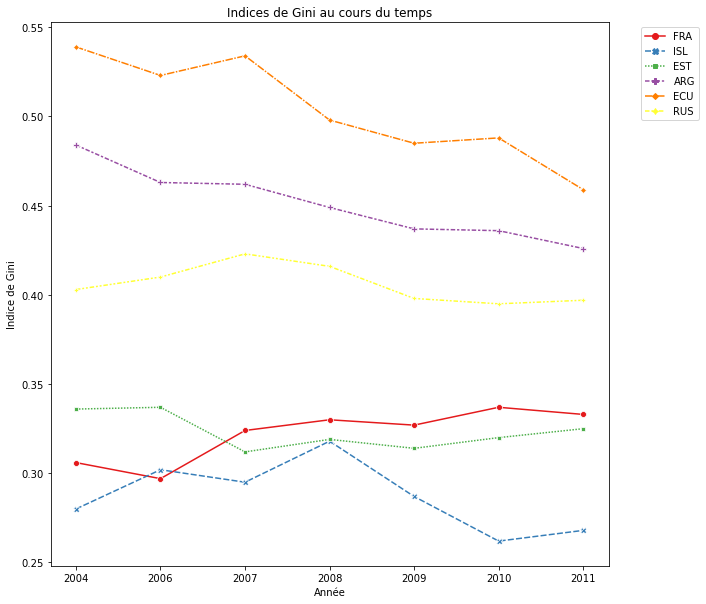

In [28]:
# Représentation graphique des indices de Gini pour nos différents pays
gini_T = gini_index.T

plt.figure(figsize=(10,10))
sns.lineplot(data=gini_T, markers=True)
plt.title('Indices de Gini au cours du temps')
plt.xlabel('Année')
plt.ylabel('Indice de Gini')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("07-Evolution indices de gini.jpg")
plt.show()

Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

In [29]:
gini_T.describe()

Country Code,FRA,ISL,EST,ARG,ECU,RUS
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.322000,0.287429,0.323286,0.451000,0.503714,0.406000
std,0.014832,0.019509,0.009962,0.020017,0.029335,0.010646
min,0.297000,0.262000,0.312000,0.426000,0.459000,0.395000
25%,0.315000,0.274000,0.316500,0.436500,0.486500,0.397500
50%,0.327000,0.287000,0.320000,0.449000,0.498000,0.403000
75%,0.331500,0.298500,0.330500,0.462500,0.528500,0.413000
max,0.337000,0.318000,0.337000,0.484000,0.539000,0.423000


Classement du GINI le plus élevé au moins élevé : Equateur, Argentine, Russie, France, Estonie, Islande.

La France fait partie des pays ayant l'indice de Gini le moins élevé ce qui montre une répartition de la richesse plutôt égale pour ce pays, bien que l'indice ait légèrement augmenté entre 2004 et 2011.

#### Calcul de la classe de revenu des parents

In [30]:
elasticity_coeff = pd.read_csv('GDIMMay2018.csv')
elasticity_coeff

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.10
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.10
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.10
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.10
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1830.0,0.023843,980.0,0.069934,NaN,NaN,NaN,NaN,0.16
6500,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,1948.0,0.010193,912.0,0.098336,NaN,NaN,NaN,NaN,0.16
6501,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,4375.0,0.016527,2269.0,0.072795,NaN,NaN,NaN,NaN,0.16
6502,Zambia,ZMB,ZMB,Sub-Saharan Africa,Developing economies,Lower middle income,0,LCMS-VI,1980,Co-residents only,...,NaN,2109.0,0.011469,1183.0,0.088865,NaN,NaN,NaN,NaN,0.16


In [31]:
elasticity_coeff = elasticity_coeff.loc[(elasticity_coeff['parent']=='avg') & (elasticity_coeff['child']=='all')]
elasticity_coeff = elasticity_coeff[['iso3', 'region', 'year', 'IGEincome']]
elasticity_coeff['IGEincome'] = elasticity_coeff['IGEincome'].fillna(0.4)

In [32]:
elasticity_coeff = elasticity_coeff.groupby('iso3').mean()
elasticity_coeff = elasticity_coeff.reset_index()
elasticity_coeff = elasticity_coeff.drop(columns='year')
elasticity_coeff

,iso3,IGEincome
0,AFG,0.400000
1,AGO,0.400000
2,ALB,0.483175
3,ARM,0.400000
4,AUS,0.375000
...,...,...
132,VNM,0.416000
133,VUT,0.400000
134,YEM,0.400000
135,ZAF,0.455400


In [33]:
data2 = pd.merge(data, elasticity_coeff, left_on='iso_code', right_on='iso3')
data2 = data2.drop(columns=['year_survey', 'Année'])
data2.head()

,Country,quantile,nb_quantiles,income,gdpppp,population_quantile,iso3,IGEincome
0,Albanie,1,100,728.89795,7297.0,28827.4,ALB,0.483175
1,Albanie,2,100,916.66235,7297.0,28827.4,ALB,0.483175
2,Albanie,3,100,1010.91600,7297.0,28827.4,ALB,0.483175
3,Albanie,4,100,1086.90780,7297.0,28827.4,ALB,0.483175
4,Albanie,5,100,1132.69970,7297.0,28827.4,ALB,0.483175


In [34]:
gini_index = gini_index.reset_index()

In [35]:
gini_index

,Country Code,2004,2006,2007,2008,2009,2010,2011
0,FRA,0.306,0.297,0.324,0.330,0.327,0.337,0.333
1,ISL,0.280,0.302,0.295,0.318,0.287,0.262,0.268
2,EST,0.336,0.337,0.312,0.319,0.314,0.320,0.325
3,ARG,0.484,0.463,0.462,0.449,0.437,0.436,0.426
4,ECU,0.539,0.523,0.534,0.498,0.485,0.488,0.459
5,RUS,0.403,0.410,0.423,0.416,0.398,0.395,0.397


In [36]:
gini_index = gini_index.drop(columns=['2004', '2006', '2007', '2009', '2010','2011'])
data2 = pd.merge(data2, gini_index, left_on = 'iso3', right_on='Country Code')
data2

,Country,quantile,nb_quantiles,income,gdpppp,population_quantile,iso3,IGEincome,Country Code,2008
0,Équateur,1,100,99.078545,7560.0,170843.58,ECU,0.525991,ECU,0.498
1,Équateur,2,100,196.350430,7560.0,170843.58,ECU,0.525991,ECU,0.498
2,Équateur,3,100,269.607300,7560.0,170843.58,ECU,0.525991,ECU,0.498
3,Équateur,4,100,350.863100,7560.0,170843.58,ECU,0.525991,ECU,0.498
4,Équateur,5,100,415.143740,7560.0,170843.58,ECU,0.525991,ECU,0.498
...,...,...,...,...,...,...,...,...,...,...
495,Fédération de Russie,96,100,20410.416000,14766.0,1457340.38,RUS,0.386000,RUS,0.416
496,Fédération de Russie,97,100,22987.898000,14766.0,1457340.38,RUS,0.386000,RUS,0.416
497,Fédération de Russie,98,100,25986.066000,14766.0,1457340.38,RUS,0.386000,RUS,0.416
498,Fédération de Russie,99,100,31600.617000,14766.0,1457340.38,RUS,0.386000,RUS,0.416


In [37]:
data2 = data2.rename(columns={'2008' : 'gini'})
data2 = data2[['iso3', 'Country', 'quantile', 'nb_quantiles','income', 'gdpppp', 'gini', 'population_quantile', 'IGEincome']]
data2

,iso3,Country,quantile,nb_quantiles,income,gdpppp,gini,population_quantile,IGEincome
0,ECU,Équateur,1,100,99.078545,7560.0,0.498,170843.58,0.525991
1,ECU,Équateur,2,100,196.350430,7560.0,0.498,170843.58,0.525991
2,ECU,Équateur,3,100,269.607300,7560.0,0.498,170843.58,0.525991
3,ECU,Équateur,4,100,350.863100,7560.0,0.498,170843.58,0.525991
4,ECU,Équateur,5,100,415.143740,7560.0,0.498,170843.58,0.525991
...,...,...,...,...,...,...,...,...,...
495,RUS,Fédération de Russie,96,100,20410.416000,14766.0,0.416,1457340.38,0.386000
496,RUS,Fédération de Russie,97,100,22987.898000,14766.0,0.416,1457340.38,0.386000
497,RUS,Fédération de Russie,98,100,25986.066000,14766.0,0.416,1457340.38,0.386000
498,RUS,Fédération de Russie,99,100,31600.617000,14766.0,0.416,1457340.38,0.386000


### Mission 3 : Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :
- le revenu moyen du pays
- l'indice de Gini du pays

Il nous manque donc, pour un individu : la classe de revenu de ses parents.

Pour chaque pays, nous allons utiliser une génération aléatoire de la classe de revenu des parents, à partir de ces seules deux informations :
- coefficient d'élasticité (pj)
- la classe de revenu de l'enfant.


#### Calcul de y_child

In [38]:
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10        # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)

#### Calcul de la classe de revenus des enfants "c_i_child" à partir de "y_child" et "y_parent"#

In [39]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample.head()

,y_child,y_parents,c_i_child,c_i_parent
0,0.149607,0.286444,1,2
1,0.778524,2.170491,5,8
2,5.160399,1.842923,9,8
3,0.350418,0.403911,3,2
4,1.131619,1.111888,6,6


In [40]:
cd = conditional_distributions(sample, nb_quantiles)

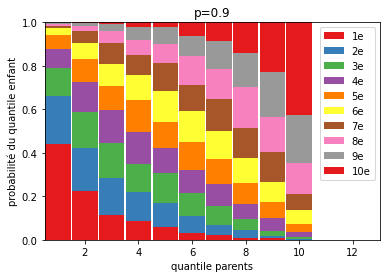

In [41]:
plot_conditional_distributions(0.9, cd, nb_quantiles)

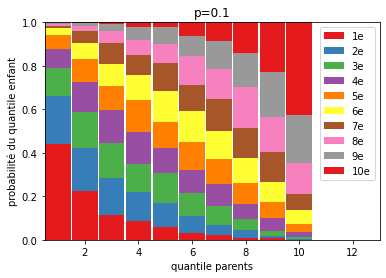

In [42]:
plot_conditional_distributions(0.1, cd, nb_quantiles)

#### Nouvel échantillon

In [43]:
del y_parents, y_child
dist_cond = data2.copy()

# On créé 499 copies de chaques enfants
new_sample = dist_cond.append([dist_cond]*499, ignore_index=True)
new_sample['c_i_parent'] = 0

dist_cond2 = new_sample.copy()
dist_pays = dist_cond2[['iso3', 'quantile', 'income', 'IGEincome', 
                        'c_i_parent', 'gini']]
# Renomme
dist_pays.columns = ['country', 'c_i_child', 'income_child', 
                     'coeff_elasticite', 'c_i_parent', 'Gj'] 

distrib_pays = dist_pays.copy()
distrib_pays.head()

,country,c_i_child,income_child,coeff_elasticite,c_i_parent,Gj
0,ECU,1,99.078545,0.525991,0,0.498
1,ECU,2,196.350430,0.525991,0,0.498
2,ECU,3,269.607300,0.525991,0,0.498
3,ECU,4,350.863100,0.525991,0,0.498
4,ECU,5,415.143740,0.525991,0,0.498


#### Attribution des classes parents

In [44]:
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = len(distrib_pays) # taille de l'échantillon
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)

distrib_pays2 = pd.concat([
    pd.DataFrame(list(zip(ln_y_parent, residus)), columns=['ln_y_parent','residus']), 
    distrib_pays], axis=1)

def generate_y_child(n, pj):
    return np.exp(pj * ln_y_parent + residus)

def generate_y_parents(n, pj):
    return np.exp(ln_y_parent)

distrib_pays2['y_child'] = 0
distrib_pays2['y_child'] = generate_y_child(n, distrib_pays['coeff_elasticite'])
distrib_pays2['y_parents'] = 0
distrib_pays2['y_parents'] = generate_y_parents(n, distrib_pays['coeff_elasticite'])

distrib_pays2['c_i_child'] = pd.qcut(distrib_pays2['y_child'], 100, labels=False) +1
distrib_pays2['c_i_parent'] = pd.qcut(distrib_pays2['y_parents'], 100, labels=False) +1

# Suppression de la variable c_i_child inutile pour la mission 4
distrib_pays2.drop(columns='c_i_child', inplace=True)

distrib_pays2

,ln_y_parent,residus,country,income_child,coeff_elasticite,c_i_parent,Gj,y_child,y_parents
0,0.990120,1.405944,ECU,99.078545,0.525991,84,0.498,6.867078,2.691556
1,1.434454,-0.242929,ECU,196.350430,0.525991,93,0.498,1.667927,4.197352
2,-0.591071,-0.412995,ECU,269.607300,0.525991,28,0.498,0.484861,0.553734
3,0.847342,-0.530161,ECU,350.863100,0.525991,81,0.498,0.919003,2.333437
4,0.396332,0.029908,ECU,415.143740,0.525991,66,0.498,1.269186,1.486362
...,...,...,...,...,...,...,...,...,...
249995,-1.303163,-0.936820,RUS,20410.416000,0.386000,10,0.416,0.236965,0.271671
249996,-1.260855,-0.618065,RUS,22987.898000,0.386000,11,0.416,0.331292,0.283412
249997,-0.660422,-0.987210,RUS,25986.066000,0.386000,26,0.416,0.288768,0.516633
249998,1.508966,1.142896,RUS,31600.617000,0.386000,94,0.416,5.614528,4.522055


In [45]:
# Création d'un dataframe avec la variable revenu moyen du pays
y_child_moy_df = distrib_pays2.groupby(by='country').mean()
y_child_moy_df.reset_index(inplace=True)
y_child_moy_df = y_child_moy_df[['country', 'income_child']]
y_child_moy_df.rename(columns={'income_child': 'mj'}, inplace=True)

y_child_moy_df

,country,mj
0,ECU,3383.741001
1,EST,7702.062593
2,FRA,18309.407545
3,ISL,26888.511518
4,RUS,7156.770709


In [46]:
# Ajout de la colonne y_child_moy
bdd_p7 = pd.merge(distrib_pays2, y_child_moy_df, on='country')
# Ajout des colonnes 'logarithmes'
bdd_p7['ln_y_child'] = np.log(bdd_p7['income_child'])
bdd_p7['ln_mj'] = np.log(bdd_p7['mj'])

bdd_p7

,ln_y_parent,residus,country,income_child,coeff_elasticite,c_i_parent,Gj,y_child,y_parents,mj,ln_y_child,ln_mj
0,0.990120,1.405944,ECU,99.078545,0.525991,84,0.498,6.867078,2.691556,3383.741001,4.595913,8.126737
1,1.434454,-0.242929,ECU,196.350430,0.525991,93,0.498,1.667927,4.197352,3383.741001,5.279901,8.126737
2,-0.591071,-0.412995,ECU,269.607300,0.525991,28,0.498,0.484861,0.553734,3383.741001,5.596966,8.126737
3,0.847342,-0.530161,ECU,350.863100,0.525991,81,0.498,0.919003,2.333437,3383.741001,5.860396,8.126737
4,0.396332,0.029908,ECU,415.143740,0.525991,66,0.498,1.269186,1.486362,3383.741001,6.028625,8.126737
...,...,...,...,...,...,...,...,...,...,...,...,...
249995,-1.303163,-0.936820,RUS,20410.416000,0.386000,10,0.416,0.236965,0.271671,7156.770709,9.923801,8.875814
249996,-1.260855,-0.618065,RUS,22987.898000,0.386000,11,0.416,0.331292,0.283412,7156.770709,10.042723,8.875814
249997,-0.660422,-0.987210,RUS,25986.066000,0.386000,26,0.416,0.288768,0.516633,7156.770709,10.165316,8.875814
249998,1.508966,1.142896,RUS,31600.617000,0.386000,94,0.416,5.614528,4.522055,7156.770709,10.360932,8.875814


### Mission 4 - Expliquer le revenu des individus en fonction de plusieurs variables explicatives

#### Représentation graphique des revenus des pays

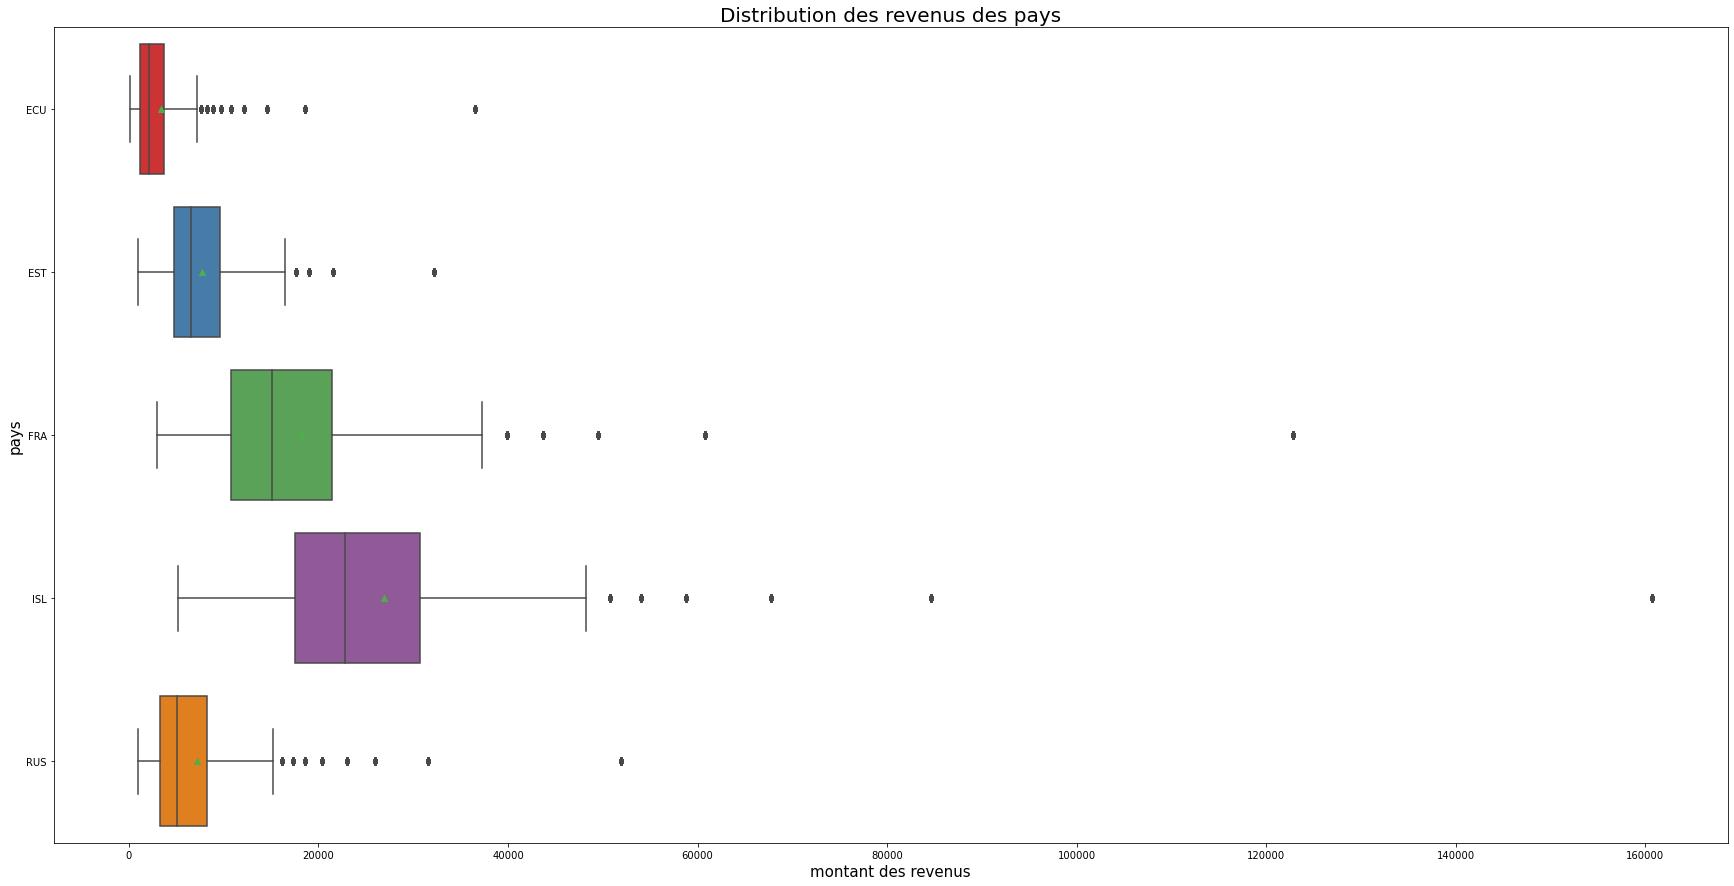

In [47]:
pays_rep = ['FRA', 'ISL', 'EST', 'ARG', 'ECU', 'RUS']
incomes_pays = bdd_p7[bdd_p7['country'].isin(pays_rep)]

plt.figure(figsize=(30,15))

sns.boxplot(
    data=incomes_pays, 
    x='income_child', y='country', showmeans=True)

plt.title("Distribution des revenus des pays", size=20)
plt.ylabel("pays", size=15)
plt.xlabel("montant des revenus", size=15)
plt.savefig("07-Distribution des revenus des pays.jpg")
plt.show()

#### ANOVA

In [48]:
data.rename({'iso3' : 'country code', 'nb_quantiles': 'nb quantiles', 'population_quantile': 'population quantile'}, axis=1, inplace=True)
data = data.drop('Année', 1)
data

,Country,year_survey,quantile,nb quantiles,income,gdpppp,population quantile
iso_code,,,,,,,
ALB,Albanie,2008,1,100,728.89795,7297.0,28827.40
ALB,Albanie,2008,2,100,916.66235,7297.0,28827.40
ALB,Albanie,2008,3,100,1010.91600,7297.0,28827.40
ALB,Albanie,2008,4,100,1086.90780,7297.0,28827.40
ALB,Albanie,2008,5,100,1132.69970,7297.0,28827.40
...,...,...,...,...,...,...,...
ZAF,Afrique du Sud,2008,96,100,24553.56800,9602.0,577925.18
ZAF,Afrique du Sud,2008,97,100,28858.03100,9602.0,577925.18
ZAF,Afrique du Sud,2008,98,100,35750.29000,9602.0,577925.18


In [49]:
alpha = 0.05
anova_pays = smf.ols('income~Country', data=data2).fit(alpha=alpha)
anova_pays.summary().tables[0]

Dep. Variable:,income,R-squared:,0.371
Model:,OLS,Adj. R-squared:,0.366
Method:,Least Squares,F-statistic:,73.09
Date:,"Fri, 11 Feb 2022",Prob (F-statistic):,1.20e-48
Time:,17:27:05,Log-Likelihood:,-5374.5
No. Observations:,500,AIC:,1.076e+04
Df Residuals:,495,BIC:,1.078e+04
Df Model:,4,,
Covariance Type:,nonrobust,,


In [50]:
print("Coefficient de détermination:", anova_pays.rsquared)
print("Le pays d'origine explique environ", 100*round(anova_pays.rsquared, 3), '% de la variance de la variable "income"')

Coefficient de détermination: 0.371331666013366
Le pays d'origine explique environ 37.1 % de la variance de la variable "income"


Nous posons donc les hypothèses suivantes :

𝐻0  : Le pays d'origine n'a aucune influence sur le revenu de l'individu.

𝐻1  : Le pays d'origine influence le revenu de l'individu.

In [51]:
# Affichage du résultat de l'ANOVA
test = sm.stats.anova_lm(anova_pays, typ=1)
test

,df,sum_sq,mean_sq,F,PR(>F)
Country,4.0,3.752781e+10,9.381951e+09,73.094653,1.195032e-48
Residual,495.0,6.353496e+10,1.283535e+08,NaN,NaN


La pvalue est inférieure à 5%, nous rejetons l'hypothèse  𝐻0 . Le pays d'origine semble donc influencer les revenus. 

Cependant, nous devons vérifier certaines conditions afin de valider l'ANOVA : la normalité des résidus et l'homogénéité des variances.

#### Vérification des conditions de validation de l'ANOVA

Représentation graphique des résidus : droite de Henry

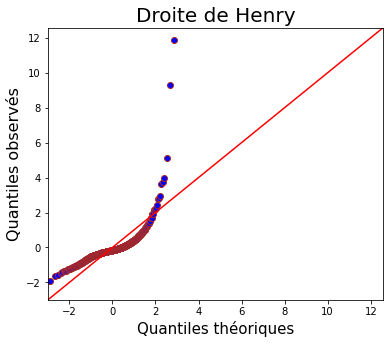

In [52]:
def residus_henry(MODEL, nom, couleur, ax):
    sm.qqplot(MODEL.resid, ax=ax, line="45", fit=True, color=couleur)
    ax.set_title("Droite de Henry", fontsize=20)
    ax.set_xlabel("Quantiles théoriques" ,fontsize=15), ax.set_ylabel("Quantiles observés", fontsize=16)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
residus_henry(anova_pays, "ANOVA", "brown", ax) ; 
plt.savefig("07-Droite de Henry ANOVA.jpg")
plt.show()

Les résidus ne semblent pas suivre une loi normale.

Test de Kolmogorov-Smirnov pour savoir si les résidus suivent une loi normale

In [53]:
def test_residus_KS(MODEL):
    MR=MODEL.resid
    KS=ks_2samp(MR,list(np.random.normal(MR.mean(), MR.std(), len(MR))))
    print("TEST DE KOLMOGOROV-SMIRNOV:", " statistic =", KS[0], " pvalue =", KS[1])

test_residus_KS(anova_pays) # ne suit pas une loi normale

TEST DE KOLMOGOROV-SMIRNOV:  statistic = 0.204  pvalue = 1.6207194560893726e-09


Test de Breusch-Pagan pour vérifier l'homoscédascité des résidus

In [54]:
def test_residus_BP(MODEL):
    BP=sm.stats.diagnostic.het_breuschpagan(MODEL.resid, MODEL.model.exog)
    print("TEST DE BREUSCH-PAGAN:", " statistic =", BP[0], " pvalue =", BP[1])
    
test_residus_BP(anova_pays) # homogénéité

TEST DE BREUSCH-PAGAN:  statistic = 8.661501228663548  pvalue = 0.07014024383550976


Les deux conditions ne sont pas validées, nous devons procéder à une alternative de l'ANOVA pour vérifier si les revenus sont bien différents selon les pays. Un test de Kruskal-Wallis sera donc réalisé.

#### Alternative à l'ANOVA : Kruskal-Wallis

In [55]:
pg.kruskal(data2, dv='income', between='Country')

,Source,ddof1,H,p-unc
Kruskal,Country,4,316.975114,2.357520e-67


La p-value est encore inférieure à 5%, et valide l'ANOVA précédente : les revenus moyens diffèrent bien entre pays.

#### Passage aux logarithmes


Distribution de la variable "y_child" avant et après le passage aux logarithmes


<Figure size 1440x1440 with 0 Axes>

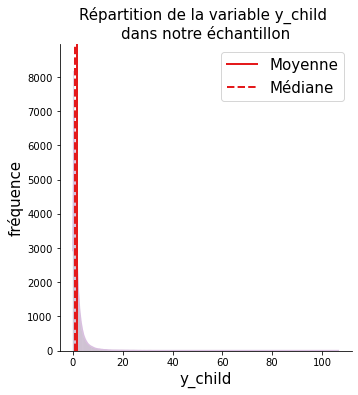

In [56]:
plt.figure(figsize = (20,20))

sns.displot(bdd_p7["y_child"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=bdd_p7["y_child"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=bdd_p7["y_child"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('y_child', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable y_child \ndans notre échantillon', size=15)
plt.legend(prop={"size":15})
plt.savefig("07-Répartition de la variable y_child.jpg")
plt.show()

<Figure size 1440x1440 with 0 Axes>

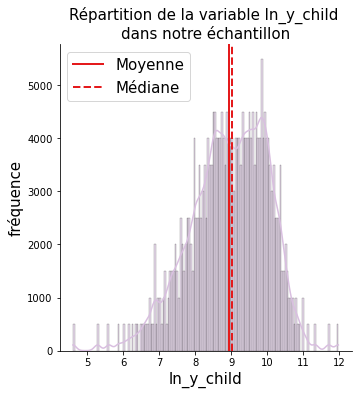

In [57]:
plt.figure(figsize = (20,20))

sns.displot(bdd_p7["ln_y_child"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=bdd_p7["ln_y_child"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=bdd_p7["ln_y_child"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('ln_y_child', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable ln_y_child \ndans notre échantillon', size=15)
plt.legend(prop={'size':15})
plt.savefig("07-Répartition de la variable y_child au logarithme.jpg")
plt.show()

#### Regression linéaire 1 : Revenu moyen du pays et indice de Gini


Hypothèses :

𝐻0: le paramètre de la variable n'est pas significatif.

𝐻1: le paramètre de la variable est significatif.

In [58]:
RL1 = smf.ols("ln_y_child ~ mj+Gj", data=bdd_p7).fit(alpha=alpha) 
RL1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_y_child   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                 1.784e+05
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:27:14   Log-Likelihood:            -2.6450e+05
No. Observations:              250000   AIC:                         5.290e+05
Df Residuals:                  249997   BIC:                         5.290e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9449      0.013    789.570      0.000       9.920       9.970
mj          6.421e-05   2.25e-07    284.813      0.000    6.38e-05    6.46e-05
Gj            -4.8229      0.028   -175.353      0.000      -4.877      -4.769
==============================================================================
Omnibus:                    10796.364   Durbin-Watson:                   0.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36524.433
Skew:                           0.047   Prob(JB):                         0.00
Kurtosis:                       4.870   Cond. No.                     3.32e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Les pvalues sont de 0, ce qui nous conduit à rejeter l'hypothèse  𝐻0, les deux variables mj et Gj sont alors significatives.

Représentation graphique : droite de Henry


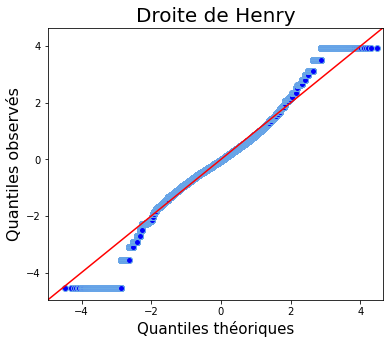

In [59]:
def analyse_des_residus(MODEL, nom, couleur):
    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
    residus_henry(MODEL, nom, couleur, ax1)
analyse_des_residus(RL1, "RL1", "#6CABE7")
plt.savefig("07-Droite de Henry RL1.jpg")
plt.show()

In [60]:
def test_residus_KS(MODEL):
    MR=MODEL.resid
    KS=ks_2samp(MR,list(np.random.normal(MR.mean(), MR.std(), len(MR))))
    print("TEST DE KOLMOGOROV-SMIRNOV:", " statistic =", KS[0], " pvalue =", KS[1])

test_residus_KS(RL1) # ne suit pas une loi normale

TEST DE KOLMOGOROV-SMIRNOV:  statistic = 0.04109600000000002  pvalue = 7.122325545916098e-184


In [61]:
def test_residus_BP(MODEL):
    BP=sm.stats.diagnostic.het_breuschpagan(MODEL.resid, MODEL.model.exog)
    print("TEST DE BREUSCH-PAGAN:", " statistic =", BP[0], " pvalue =", BP[1])
    
test_residus_BP(RL1) # homogénéité

TEST DE BREUSCH-PAGAN:  statistic = 16663.641169526705  pvalue = 0.0


#### Regression linéaire 2 : Revenu moyen du pays au logarithme et indice de Gini

In [62]:
RL2 = smf.ols("ln_y_child ~ ln_mj+Gj", data=bdd_p7).fit(alpha=alpha) 
RL2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_y_child   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 1.880e+05
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:27:15   Log-Likelihood:            -2.6061e+05
No. Observations:              250000   AIC:                         5.212e+05
Df Residuals:                  249997   BIC:                         5.213e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3085      0.042      7.342      0.000       0.226       0.391
ln_mj          1.0081      0.003    302.604      0.000       1.002       1.015
Gj            -1.6778      0.034    -48.694      0.000      -1.745      -1.610
==============================================================================
Omnibus:                    10716.816   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35194.671
Skew:                           0.081   Prob(JB):                         0.00
Kurtosis:                       4.831   Cond. No.                         360.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

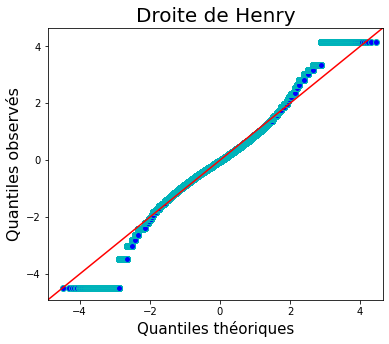

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
residus_henry(RL2, "RL2", "#00BAB9", ax) 
plt.savefig("07-Droite de Henry RL2.jpg")
plt.show()

In [64]:
def test_residus_KS(MODEL):
    MR=MODEL.resid
    KS=ks_2samp(MR,list(np.random.normal(MR.mean(), MR.std(), len(MR))))
    print("TEST DE KOLMOGOROV-SMIRNOV:", " statistic =", KS[0], " pvalue =", KS[1])

test_residus_KS(RL2) # ne suit pas une loi normale

TEST DE KOLMOGOROV-SMIRNOV:  statistic = 0.039252000000000065  pvalue = 8.93596377516343e-168


In [65]:
def test_residus_BP(MODEL):
    BP=sm.stats.diagnostic.het_breuschpagan(MODEL.resid, MODEL.model.exog)
    print("TEST DE BREUSCH-PAGAN:", " statistic =", BP[0], " pvalue =", BP[1])
    
test_residus_BP(RL2) # homogénéité

TEST DE BREUSCH-PAGAN:  statistic = 17417.34481695914  pvalue = 0.0


R² est supérieure à celui de la précédente RL, le passage au logarithme a renforcé le modèle.

On observe que les résidus du second modèle (passage aux logarithmes) suivent plus une loi normale que ceux du premier modèle (pvalue plus faible). Le passage aux logarithmes permet donc d'avoir un modèle plus viable.

#### Regression linéaire 3 : revenu moyen au log, indice de Gini et classe de revenu des parents

In [66]:
RL3= smf.ols("ln_y_child ~ ln_mj+Gj+c_i_parent", data=bdd_p7).fit(alpha=alpha) 
RL3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_y_child   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 1.254e+05
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:27:17   Log-Likelihood:            -2.6061e+05
No. Observations:              250000   AIC:                         5.212e+05
Df Residuals:                  249996   BIC:                         5.213e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3054      0.042      7.257      0.000       0.223       0.388
ln_mj          1.0081      0.003    302.606      0.000       1.002       1.015
Gj            -1.6777      0.034    -48.691      0.000      -1.745      -1.610
c_i_parent  5.747e-05   4.75e-05      1.209      0.227   -3.57e-05       0.000
==============================================================================
Omnibus:                    10716.907   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35195.836
Skew:                           0.081   Prob(JB):                         0.00
Kurtosis:                       4.831   Cond. No.                     2.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

La variance expliquée est la même que précédemment, qu'on ajoute c_i_parent ou non.

Représentation graphique : droite de Henry

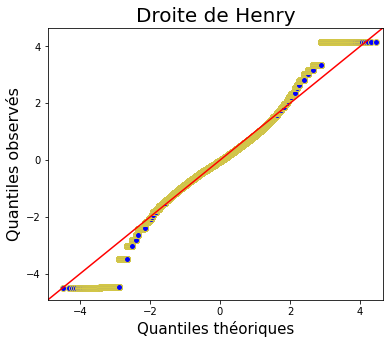

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
residus_henry(RL3, "RL3", "#D8CC46", ax) 
plt.savefig("07-Droite de Henry RL3.jpg")
plt.show()

In [68]:
def test_residus_KS(MODEL):
    MR=MODEL.resid
    KS=ks_2samp(MR,list(np.random.normal(MR.mean(), MR.std(), len(MR))))
    print("TEST DE KOLMOGOROV-SMIRNOV:", " statistic =", KS[0], " pvalue =", KS[1])

test_residus_KS(RL3) # ne suit pas une loi normale

TEST DE KOLMOGOROV-SMIRNOV:  statistic = 0.03636399999999995  pvalue = 4.7559648186042514e-144


In [69]:
def test_residus_BP(MODEL):
    BP=sm.stats.diagnostic.het_breuschpagan(MODEL.resid, MODEL.model.exog)
    print("TEST DE BREUSCH-PAGAN:", " statistic =", BP[0], " pvalue =", BP[1])
    
test_residus_BP(RL3) # homogénéité

TEST DE BREUSCH-PAGAN:  statistic = 17417.97279164775  pvalue = 0.0


#### Regression linéaire 4 : ajout des variables restantes

In [70]:
RL4=smf.ols("ln_y_child ~ ln_mj+Gj+c_i_parent+ln_y_parent+coeff_elasticite", data=bdd_p7).fit(alpha=alpha) ; RL4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_y_child   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 7.526e+04
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:27:19   Log-Likelihood:            -2.6056e+05
No. Observations:              250000   AIC:                         5.211e+05
Df Residuals:                  249994   BIC:                         5.212e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.4466      0.045      9.902      0.000       0.358       0.535
ln_mj                1.0055      0.003    300.848      0.000       0.999       1.012
Gj                  -1.4374      0.042    -34.113      0.000      -1.520      -1.355
c_i_parent          -0.0004      0.000     -1.768      0.077      -0.001    4.29e-05
ln_y_parent          0.0134      0.006      2.075      0.038       0.001       0.026
coeff_elasticite    -0.4373      0.044     -9.900      0.000      -0.524      -0.351
==============================================================================
Omnibus:                    10638.971   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34571.381
Skew:                           0.086   Prob(JB):                         0.00
Kurtosis:                       4.814   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Représentation graphique : droite de Henry

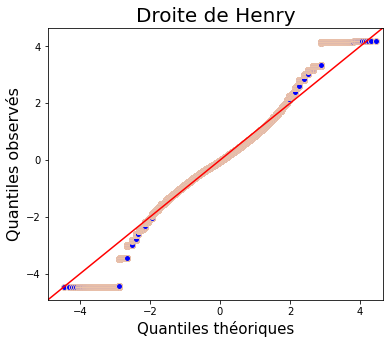

In [71]:
analyse_des_residus(RL4, "RL4", "#EEC5A9") 
plt.savefig("07-Droite de Henry RL4.jpg")
plt.show()

La distribution est proche d'une loi normale

In [72]:
def test_residus_KS(MODEL):
    MR=MODEL.resid
    KS=ks_2samp(MR,list(np.random.normal(MR.mean(), MR.std(), len(MR))))
    print("TEST DE KOLMOGOROV-SMIRNOV:", " statistic =", KS[0], " pvalue =", KS[1])

test_residus_KS(RL4) # ne suit pas une loi normale

TEST DE KOLMOGOROV-SMIRNOV:  statistic = 0.03987200000000002  pvalue = 4.178092740020423e-173


In [73]:
def test_residus_BP(MODEL):
    BP=sm.stats.diagnostic.het_breuschpagan(MODEL.resid, MODEL.model.exog)
    print("TEST DE BREUSCH-PAGAN:", " statistic =", BP[0], " pvalue =", BP[1])
    
test_residus_BP(RL4) # homogénéité

TEST DE BREUSCH-PAGAN:  statistic = 18008.626498887377  pvalue = 0.0


In [74]:
print("Ce nouveau modèle explique environ", round(100*RL4.rsquared, 2), '% de la variance de la variable "ln_y_child"')

Ce nouveau modèle explique environ 60.08 % de la variance de la variable "ln_y_child"


Corrélation entre le revenu de l'enfant et l'indice de Gini des pays

<ipython-input-75-cb8bc3838387>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))


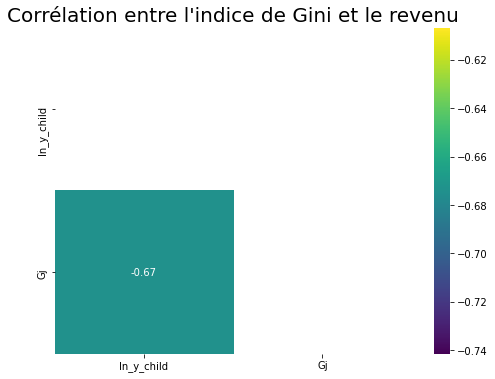

In [75]:
correlation_matrix = bdd_p7[['ln_y_child', 'Gj']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='viridis')
plt.title("Corrélation entre l'indice de Gini et le revenu", size=20)
plt.savefig("07-Corrélation entre l'indice de Gini et le revenu.jpg")
plt.show()

On observe une corrélation négative entre les deux variables les plus explicatives : plus l'indice de Gini est bas, plus le revenu moyen du pays a tendance à être haut.